Apparent Competition

In [8]:
push!(LOAD_PATH, pwd()) # put current directory on path
using Revise
using UnPack
#include("ModelHelperFuns.jl")  # load the file
#using .ModelHelperFuns         # bring the module into scope
using CooperativeHuntingPkg
using Plots
default(
    guidefontsize=17,   # controls xlabel, ylabel, title font size
    tickfontsize=12,    # controls axis number labels
    legendfontsize=14,  # controls legend font
    linewidth=4,        # controls default line thickness
    grid = false,        # turns off grid in background
    fontfamily="Computer Modern" # font family that matches latex
)
using BifurcationKit, DifferentialEquations
# pgfplotsx()  # Set PGFPlotsX as the backend # this seems to not work on my computer, or on vscode.
using Measures # helps for adjusting location of axis labels
using LinearAlgebra
using ForwardDiff #this should be able to numerically find a jacobian
using LaTeXStrings

# saving with bif diagrams
bif_fig_path = "/Users/taliaborofsky/Documents/Postdoc/Collaborations/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"

"/Users/taliaborofsky/Documents/Postdoc/Collaborations/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"

# Functions and label dictionaries

In [5]:
# these were supposed to load with my package but i guess it didn't work
ylabel_dic = Dict(
    :N1 => L"N_1"*", Scaled Big Prey\nDensity",
    :N2 => L"N_2"*", Scaled Small Prey\nDensity",
    :mean_x => "Mean Experienced\nGroup Size, "*L"\bar{x}",
    :p => L"Predator density, $p$",
    :Nsum => "Sum of Prey Densities,\n"*L"N_1 + N_2",
    :g1 => L"g(1)",
    :g2 => L"g(2)",
    :g3 => L"g(3)"
)

param_label_dic = Dict(
    :α1_of_1 => L"\alpha_1(1)",
    :α2_of_1 => L"\alpha_2(1)",
    :s1 => L"s_1",
    :s2 => L"s_2",
    :H1a => L"H_{1a}",
    :H2a => L"H_{2a}",
    :H2b => L"H_{2b}",
    :A1 => L"Relative Attack Rate of Big Prey, $A_1$",
    :A2 => L"A_2",
    :η2 => L"Growth of Small Prey, $\eta_2$",
    :β2 => L"\beta_2",
    :x_max => L"x_{max}",
    :Tg => "Relative Group Dynamics \nTimescale, "*L"T_g",
    :d => L"d",
    :scale => L"Benefit Ratio, $\beta_1/\beta_2$"
)
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 10,
    :Tg => .01,
    :d => 100.0,
    :scale => 5.0
)
function get_apparent_comp_bothways(stable_coexist, gmat, params)
    num = length(stable_coexist[:N1])
    ∂N2_∂N1 = zeros(num)
    ∂N1_∂N2 = zeros(num)
    for i in 1:num
        # set up inputs
        N1 = stable_coexist[:N1][i]
        N2 = stable_coexist[:N2][i]
        g = gmat[i,:]
        params_use = deepcopy(params)
        params_use[:scale] = stable_coexist[:param][i]
        params_use = scale_parameters(params_use)
        @unpack scale, β1, β2, η1, η2, A1, A2, H1b, H2b = params_use
        # get jacobian
        #J= ForwardDiff.jacobian(u->fullsystem_scaled(u,params_use), [N1,N2,g...])
        J = Jacobian(N1,N2,g,params_use)
        ∂N2_∂N1[i] = get_∂N2_∂N1(J)
        ∂N1_∂N2[i] = get_∂N1_∂N2(J)
    end
    return ∂N2_∂N1, ∂N1_∂N2
end

function get_stable_equilibria( params; 
    lens = (@optic _.scale), p_min = 1.01, p_max = 8.0
    )

    @unpack x_max = params
    u0 = fill(0.1, x_max+2)
    p_nt = NamedTuple(scale_parameters(params))
    br_list = do_base_continuations(
        p_nt, x_max;
        lens = lens, p_min = p_min, p_max = p_max
        );

    br_coexist = br_list[:coexist]
    filtered_coexist = extract_branch_matrix(br_coexist, params[:x_max])
    indices = findall(xvec -> xvec==1.0, filtered_coexist.stable)

    stable_coexist = Dict()
    for (key, value) in pairs(filtered_coexist)
        stable_coexist[key] = value[indices]
    end

    # store g's in a matrix
    gmat = fill(1.0, (length(stable_coexist[:N1]), params[:x_max]))
    for i in 1:x_max
        gmat[:,i] = stable_coexist[Symbol("g$i")]
    end
    return stable_coexist, gmat
end
function plot_distribution_heatmap(gmat, stable_coexist, x_max)
    # prob_x_mat: matrix (rows = param values, cols = x values)
    prob_x_mat = get_prob_in_x(gmat, stable_coexist[:P], x_max);
    # stable_coexist[:param]: vector for x-axis
    # xvec: vector for y-axis (e.g., 1:x_max)
    xvec = 1:x_max
    plt_heat = heatmap(
        stable_coexist[:param], 
        xvec, 
        prob_x_mat', 
        color = :coolwarm,         # black (1) to white (0)
        clim = (0, maximum(prob_x_mat) + .01),          # scale from 0 (white) to 1 (black)
        xlabel = param_label_dic[:scale], 
        ylabel = L"Group size, $x$",
        right_margin = 15mm,
        #colorbar_titlefontrotation = 180,
        yflip = false            # optional: flip y-axis if you want black at the top
    )
    plot!(
        stable_coexist[:param],
        stable_coexist[:mean_x],
        label = L"\bar{x}",
        color = :black,
        linewidth=4
    )
    annotate!(
        (1.2, 0.5),
        text(L"\textrm{Prob.\ in\ group\ size}\ x", 16, :center, rotation = -90),
        
    )
    return plt_heat
end

function find_mangel_clark(N1, N2, params)
    # Mangel and Clark predicted that groups should grow until W(x^*) = W(1)
    # Simplest way: iterate and stop when W(x) < W(1), then return x - 1
    @unpack x_max = params
    W_of_1 = fun_W(1, N1, N2, params)
    for x in 2:x_max
        W_of_x = fun_W(x, N1, N2, params)
        if W_of_x < W_of_1
            return x - 1
        end
    end
    return x_max  # If reach x_max
end

function plot_mc_line(plt, stable_coexist, params_base)
    x_list_mangel_clark = []
    params = deepcopy(params_base)
    for (i,param) in enumerate(stable_coexist[:param])
        # get parameter value and prey values
        N1 = stable_coexist[:N1][i]
        N2 = stable_coexist[:N2][i]
        params[:scale] = param

        # update parameters dictionary using scaling laws
        params = scale_parameters(params)

        # get mangel and clark prediction
        x_mc = find_mangel_clark(N1, N2, params)
        push!(x_list_mangel_clark, x_mc)
    end
    # plot
    plot!(stable_coexist[:param], x_list_mangel_clark, color = :yellow,
    label=L"Clark & Mangel $\hat{x}$")
end

function plot_opt_line(plt, stable_coexist, params_base)
    """
    Plots the group size that maximizes fitness atht eequilibrium
    """
    x_list = []
    params = deepcopy(params_base)
    for (i,param) in enumerate(stable_coexist[:param])
        # get parameter value and prey values
        N1 = stable_coexist[:N1][i]
        N2 = stable_coexist[:N2][i]
        params[:scale] = param

        # update parameters dictionary using scaling laws
        params = scale_parameters(params)

        # get mangel and clark prediction
        W = fun_W(1:params_base[:x_max], N1, N2, params)
        x_opt = findmax(W)[2]
        push!(x_list, x_opt)
    end
    plot!(
        stable_coexist[:param], x_list, color = :purple,
        linewidth=5,
        label = L"x^*"
        )

end

plot_opt_line (generic function with 1 method)

# Type I, varying scale

## Get stable equilibria

In [6]:
params_t1 = deepcopy(params_base)
params_t1[:x_max] = 10
stable_coexist_t1, gmat_t1 = get_stable_equilibria(params_t1)

[0.21836024456051684, 0.5067998895455946, 0.419636248904051, 0.1285548153743295, 0.07458386338926003, 0.0002142146055803457, 3.8341055617855367e-7, 5.708900194815018e-10, 7.285575141768388e-13, 8.135376352767739e-16, 8.074908750271609e-19, 7.213395563403075e-22][1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.6767218167740066, 0.0, 0.0029504257084259195, 0.0013129606411649499, 0.002047851230639476, 0.0040662673127916295, 0.006737113395990582, 0.00932505605593189, 0.01106065144745292, 0.011484679994888267, 0.01057803567979227, 0.008666638109609071][0.0, 0.5902982408277694, 0.5167947777867937, 0.0007225713501215632, 6.340415388309203e-7, 6.966072640874746e-8, -8.334918023862401e-8, 6.977046625141343e-8, -4.0082967482086454e-8, 1.513110314204639e-8, -3.391748950814585e-9, 3.433636773556404e-10][0.9998489945252559, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.0, 0.9995805607141938, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

┌ Error: Failure to converge with given tolerance = 1.0e-12.
│ Step = 309
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 309.
└ @ BifurcationKit /Users/taliaborofsky/.julia/packages/BifurcationKit/nhoqA/src/continuation/Contbase.jl:67


(Dict{Any, Any}(:g6 => [0.0066607169569291485, 0.004745673065455537, 0.0033757517156446514, 0.002400078472847427, 0.0017070471960130196, 0.0012154490267155555, 0.0008668558375949689, 0.0006195535292512968, 0.0004439156826384502, 0.00031897157054416235  …  4.060447536607735e-10, 4.054190811722289e-10, 4.047943032162835e-10, 4.04170417199589e-10, 4.035474205821887e-10, 4.029253108762416e-10, 4.0230408564485377e-10, 4.0168374250097326e-10, 4.010642791059251e-10, 4.0097249748184806e-10], :g5 => [0.03624638685384051, 0.0303185475667079, 0.025276757899584244, 0.021025136499342456, 0.01746245068303851, 0.014490955967533085, 0.01202095904611467, 0.009972773176016645, 0.008277138621897606, 0.00687478699845158  …  2.3666210015572378e-7, 2.3620168661234657e-7, 2.357425216635073e-7, 2.3528459834936007e-7, 2.3482790979118103e-7, 2.3437244919002598e-7, 2.339182098254407e-7, 2.334651850542247e-7, 2.3301336830904268e-7, 2.329464736578164e-7], :g3 => [0.27246774200140844, 0.2767830771001066, 0.28012192

In [7]:
∂N2_∂N1_t1, ∂N1_∂N2_t1 = get_apparent_comp_bothways(
    stable_coexist_t1, gmat_t1, params_t1
    )

([-1.4504416279087775, -1.4074658503608168, -1.3772456881850261, -1.3561363899639631, -1.3417703585417302, -1.3325397224246807, -1.3273118301691842, -1.3252637628680428, -1.325781517443105, -1.328396170666137  …  -3.9493787017625133, -3.9512179102295453, -3.953044835635335, -3.954859524850733, -3.9566620246374873, -3.958452381608267, -3.960230642245087, -3.961996852923271, -3.9637510598425596, -3.964010161164899], [-0.813529698721784, -0.8301019642033146, -0.8424938151048889, -0.8515936882623134, -0.8580668188619998, -0.862422099914148, -0.8650559407602296, -0.8662819594691923, -0.8663516254344654, -0.865468937672988  …  -0.328910663923303, -0.32869245456604157, -0.328475352358832, -0.3282593509160863, -0.32804444389907855, -0.32783062501607707, -0.3276178880209718, -0.3274062267150857, -0.3271956349424925, -0.32716449827840705])

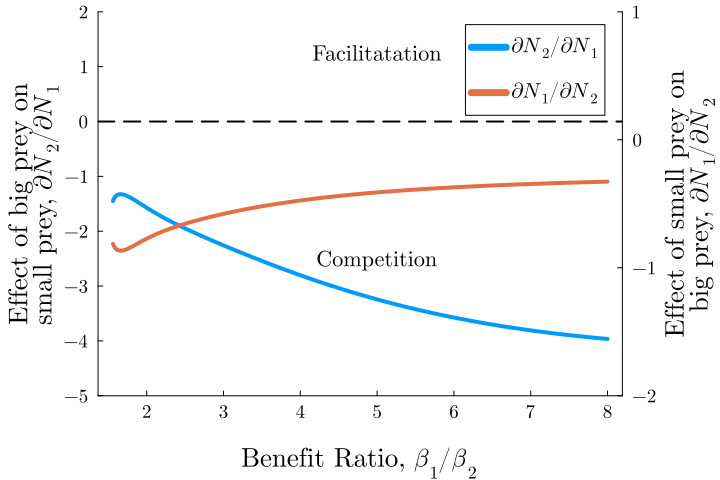

In [9]:
plt = plot(
    stable_coexist_t1[:param], # i looked at the values and 207 is about where there's a change
    ∂N2_∂N1_t1, 
    label = L"\partial N_2/\partial N_1", 
    color = 1, 
    ylabel = "Effect of big prey on\n"*L"small prey, $\partial N_2/\partial N_1$",
    xlab = "\n"*param_label_dic[:scale],
    ylims = [-5,2]
    )
annotate!((5.0,1.25,"Facilitatation"))
annotate!((5.0,-2.5,"Competition"))
plot!([],[], color = :white, label = " ")
plot!([],[], color = 2,label = L"\partial N_1/\partial N_2") # need this in order to show both labels
plot!(
    twinx(), stable_coexist_t1[:param], ∂N1_∂N2_t1, 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = "Effect of small prey on\n"*L"big prey, $\partial N_1/\partial N_2$",
    color = 2,
    ylims = [-2,1])
hline!([0], color = :black, linestyle = :dash, linewidth = 2, label = nothing)
plot!(
    legend = :topright,
    bottommargin = 3mm, # prevents xlab from being cutoff
    right_margin=4mm,
    left_margin=4mm,
    size = (720,480)
)

savefig(plt, bif_fig_path*"apparent_comp_t1_scale.pdf")
plt


## Plot Distribution

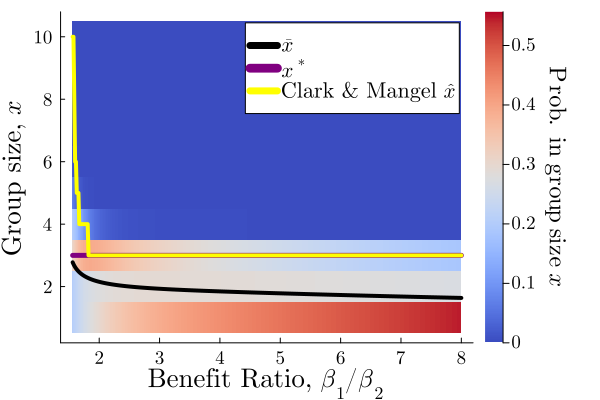

In [10]:
x_max = params_t1[:x_max]
plt = plot_distribution_heatmap(gmat_t1, stable_coexist_t1, x_max)
plot_opt_line(plt, stable_coexist_t1, params_t1)
plot_mc_line(plt, stable_coexist_t1, params_t1)
savefig(plt, bif_fig_path*"distribution_t1_scale.pdf")
plt


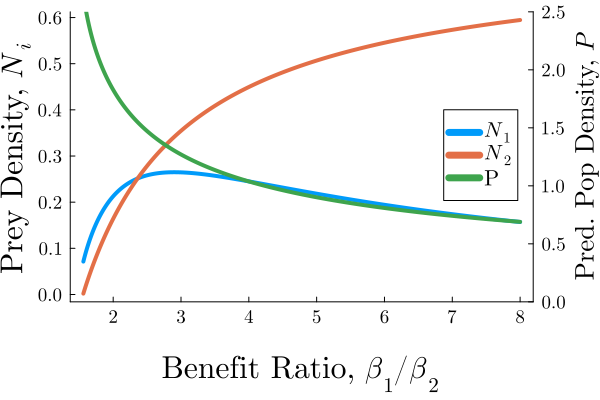

In [11]:
#size_explanatory_plots = (600, 133)
plt_N = plot(
    stable_coexist_t1[:param], 
    stable_coexist_t1[:N1], 
    label = L"N_1",
    linewidth=4
    )
plot!(
    stable_coexist_t1[:param], 
    stable_coexist_t1[:N2], 
    label = L"N_2",
    linewidth=4
    )
plot!([],[],color=3, linewidth=4, label = "P")
plot!(ylab = L"Prey Density, $N_i$",
    xlab = "\n"*param_label_dic[:scale],
    bottommargin = 5mm,
    guidefontsize=20,
    legend = :right
    )#ylab = "Scaled Prey Density\nat Equilibrium"
plot!(
    twinx(), stable_coexist_t1[:param], stable_coexist_t1[:P], 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = L"Pred. Pop Density, $P$",
    color = 3,
    linewidth=4,
    ylims = [0,2.5])
savefig(plt_N, bif_fig_path*"stable_N_t1_scale.pdf")
plt_N


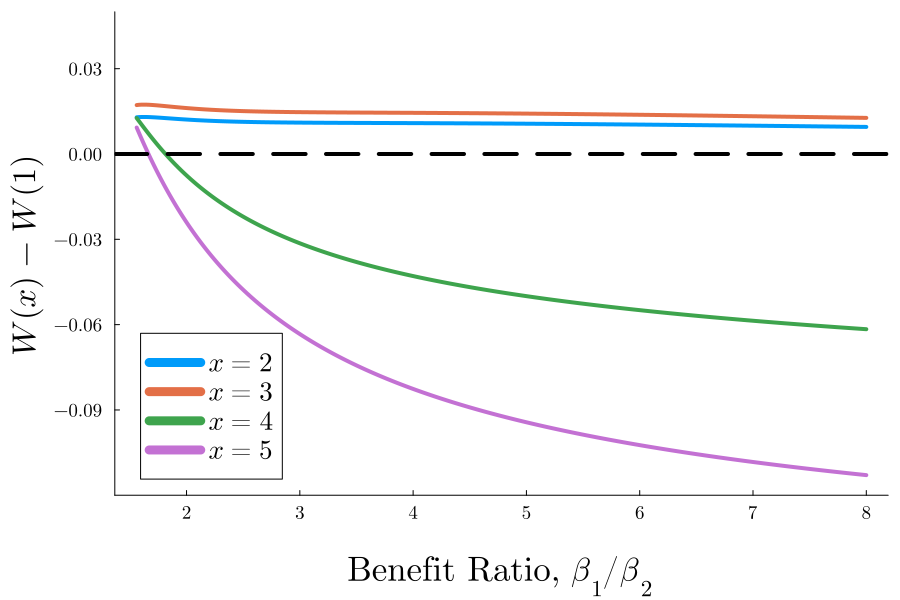

In [12]:
# explanatory figures
# get W mat
num = length(stable_coexist_t1[:N1])
xvec = 1:x_max
Wmat = zeros(num,x_max)
for i in 1:num
    # set up inputs
    N1 = stable_coexist_t1[:N1][i]
    N2 = stable_coexist_t1[:N2][i]
    params_use = deepcopy(params_t1)
    params_use[:scale] = stable_coexist_t1[:param][i]
    params_use = scale_parameters(params_use)
    
    Wmat[i,:] = fun_W(xvec,N1,N2,params_use)
end
# plot heatmap of W
# stable_coexist_t1[:param]: vector for x-axis
# xvec: vector for y-axis (e.g., 1:x_max)
xvec = 1:x_max
plt = plot(
    xlab = "\n"*param_label_dic[:scale],
    ylab = L"W(x) - W(1)",
    bottommargin=5mm)
for x in 2:5
    plot!(stable_coexist_t1[:param], Wmat[:,x] .- Wmat[:,1], label = L"x=%$x",
    guidefontsize=22, left_margin = 5mm, legendfontsize=18,
    linewidth=4,
    )
end
plot!(ylim = [-0.12,0.05])
hline!([0],linestyle=:dash, color = :black, label = nothing,size=(600,400).*1.5)
savefig(plt, bif_fig_path*"W_t1_scale.pdf")
plt



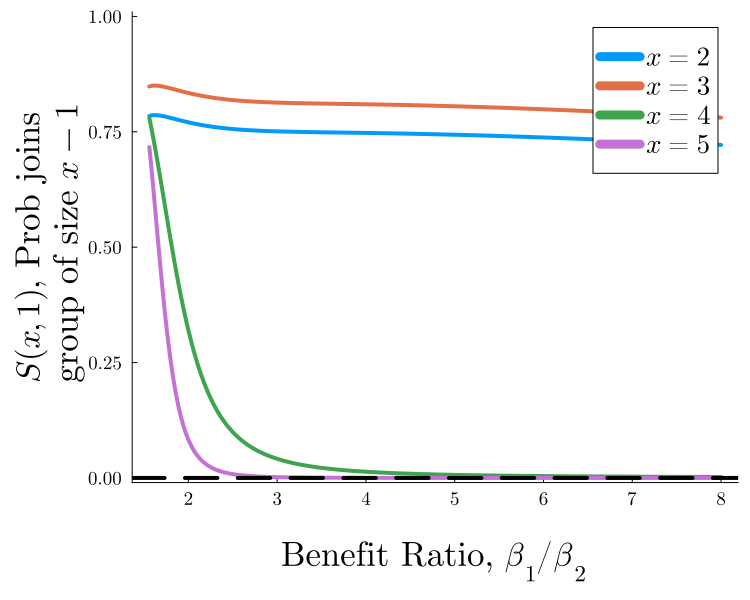

In [13]:
# explanatory figures
# get W mat
num = length(stable_coexist_t1[:N1])
xvec = 1:x_max
Wmat = zeros(num,x_max)
for i in 1:num
    # set up inputs
    N1 = stable_coexist_t1[:N1][i]
    N2 = stable_coexist_t1[:N2][i]
    params_use = deepcopy(params_t1)
    params_use[:scale] = stable_coexist_t1[:param][i]
    params_use = scale_parameters(params_use)
    
    Wmat[i,:] = fun_W(xvec,N1,N2,params_use)
end
# plot heatmap of W
# stable_coexist[:param]: vector for x-axis
# xvec: vector for y-axis (e.g., 1:x_max)
xvec = 1:x_max
plt = plot(
    xlab = "\n"*param_label_dic[:scale],
    ylab = L"$S(x,1)$, Prob joins"*"\n group of"* L" size $x-1$",
    bottommargin=5mm)
for x in 2:5 #xvec[2:end]
    plot!(
        stable_coexist_t1[:param], 
        1 ./(1 .+ exp.(-params_t1[:d] .* (Wmat[:,x] .- Wmat[:,1]))), 
        label = L"x=%$x",
    guidefontsize=22, left_margin = 5mm, legendfontsize=18,
    linewidth=4,
    )
end
plot!(ylim = [-0.01,1.01])
hline!([0],linestyle=:dash, color = :black, label = nothing,size=(500,400).*1.5)
#savefig(plt, bif_fig_path*"W_t1_scale.pdf")
plt



## Scale vs eta2

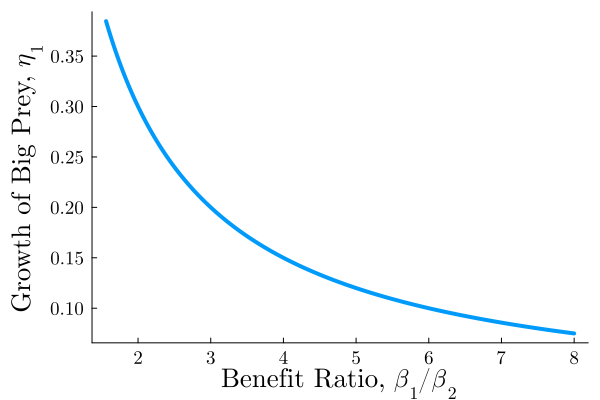

In [14]:
scale = stable_coexist_t1[:param]
η2 = params_t1[:η2]
η1 = η2 ./ scale

plot(
    scale, η1, label = nothing,
    ylab = L"Growth of Big Prey, $\eta_1$",
    xlab = param_label_dic[:scale],
    left_margin = 5mm)

- compare this to group size without population dynamics
    to isolate the population dynamics is reducing group sizes
- need to S(x,1) curves
- even though most predators are singletons, there aren't many predators, which reduces the rate of group formation from predators running into each other

# Type II, varying scale

## Get Stable Equilibria

In [15]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 10,
    :Tg => .01,
    :d => 100.0,
    :scale => 5.0
)
# type II, vary scale
params_t2 = deepcopy(params_base)
params_t2[:H1a] = params_t2[:H2a] = 0.0
params_t2[:H2b] = 1.0
stable_coexist_t2, gmat_t2 = get_stable_equilibria(params_t2)
∂N2_∂N1_t2, ∂N1_∂N2_t2 = get_apparent_comp_bothways(stable_coexist_t2, gmat_t2, params_t2)

[0.5806956966568686, 0.8726891171198384, 0.12013326613846508, 0.07723004323433492, 0.14630196544616336, 0.011493701227469975, 6.911807408171758e-5, 1.5733190187257245e-7, 2.887442554324417e-10, 4.828661403442928e-13, 7.506906285007746e-16, 1.091855779834982e-18][1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.9999999999891476, 0.0, 1.2937264598895544e-8, -3.0142720768337584e-10, 6.121492928256059e-10, -3.0651207404610207e-9, 1.147140459551657e-8, -3.184313611226066e-8, 6.603828892629319e-8, -9.976227086522955e-8, 9.889250953619342e-8, -4.2243112799176975e-8][0.0, 0.9999999999999467, -5.768839246615161e-9, 2.6085791873048875e-8, -6.989993492205568e-8, 1.229761342444703e-7, -1.4846114329683336e-7, 1.245810935436039e-7, -7.178033370860253e-8, 2.719379649056383e-8, -6.124057074948218e-9, 6.24018294137066e-10][0.9998489945252559, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.0, 0.9995805607141938, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

([-1.4315956442281983, -1.3851892755698154, -1.3510461141436314, -1.325609516738877, -1.3065620706338896, -1.2923277077325637, -1.2817964943880662, -1.2741638596859088, -1.2688322870279964, -1.2653488490799791  …  -3.195948867396259, -3.1725143687377373, -3.149566464390064, -3.1270929207039866, -3.1050818605464006, -3.0835217500407706, -3.0624013858851145, -3.0417098832507334, -3.0214366641958073, -3.018270065371257], [-0.8245648713144832, -0.8433337270884227, -0.8581534046077096, -0.8698716119144998, -0.8791217525812978, -0.8863865072598143, -0.8920397768446722, -0.8963752167354261, -0.8996261637139329, -0.9019798682233203  …  -0.3722194733005892, -0.37317686982971343, -0.3741201194165694, -0.37504919654385066, -0.3759640822663098, -0.37686476416425124, -0.3777512362924822, -0.3786234991228643, -0.37948155948128454, -0.3796158775896927])

## Plot Apparent Competition

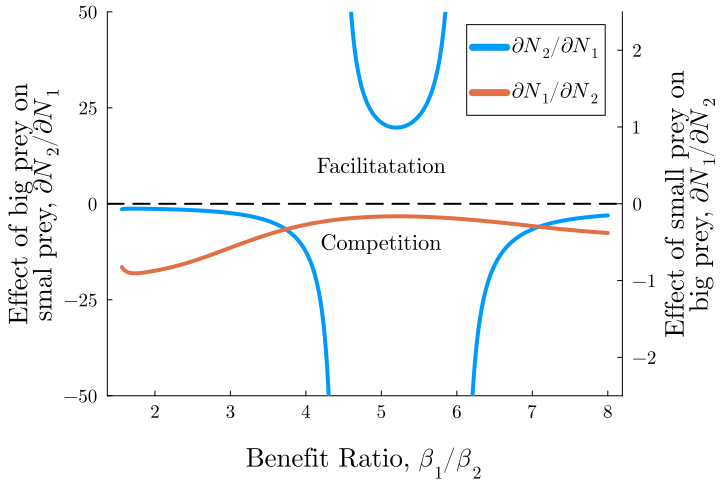

In [16]:
ix_end_below_1 = findfirst( ∂N2_∂N1_t2.> 0)
ix_end_above = findlast( ∂N2_∂N1_t2.> 0)
plt = plot(
    stable_coexist_t2[:param][1:ix_end_below_1 - 1], # i looked at the values and 207 is about where there's a change
    ∂N2_∂N1_t2[1:ix_end_below_1 - 1], 
    label = L"\partial N_2/\partial N_1", 
    color = 1, 
    ylabel = "Effect of big prey on\n"*"smal prey, "*L"\partial N_2/\partial N_1",
    xlab = "\n"*param_label_dic[:scale],
    ylims = [-50,50]
    )
annotate!((5.0,10,"Facilitatation"))
annotate!((5.0,-10,"Competition"))
plot!(stable_coexist_t2[:param][ix_end_below_1:ix_end_above], ∂N2_∂N1_t2[ix_end_below_1:ix_end_above], 
    label = nothing, color = 1)
plot!(stable_coexist_t2[:param][ix_end_above+1:end], ∂N2_∂N1_t2[ix_end_above+1:end], 
    label = nothing, color = 1)
plot!([], [], color = :white, label = " ")
plot!([],[], color = 2,label = L"\partial N_1/\partial N_2")
plot!(
    twinx(), stable_coexist_t2[:param], ∂N1_∂N2_t2, 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = "Effect of small prey on\n"*L"big prey, $\partial N_1/\partial N_2$",
    color = 2,
    ylims = [-2.5,2.5])
hline!([0], color = :black, linestyle = :dash, linewidth = 2, label = nothing)
plot!(
    legend = :topright,
    rightmargin=4mm,
    leftmargin=4mm,
    bottommargin = 3mm, # prevents xlab from being cutoff
    size=(720,480)
)

savefig(plt, bif_fig_path*"apparent_comp_t2_scale.pdf")
plt


## Explanatory figures: distribution, p, N1, N2, W

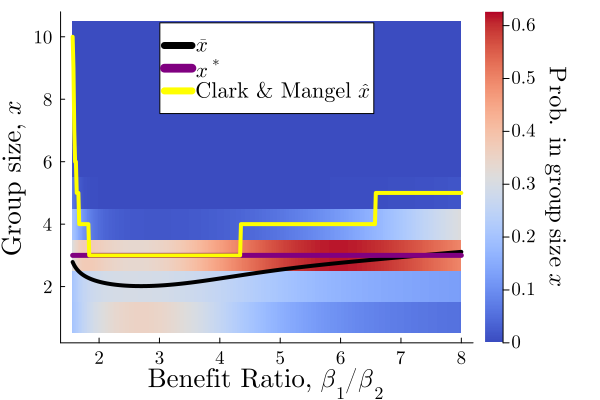

In [17]:
plt_heat = plot_distribution_heatmap(gmat_t2, stable_coexist_t2, params_t2[:x_max])
plot_opt_line(plt, stable_coexist_t2, params_t2)
plot_mc_line(plt, stable_coexist_t2, params_t2)
plot!(legend=:top)
savefig(plt_heat, bif_fig_path*"distribution_t2_scale.pdf")
plt_heat


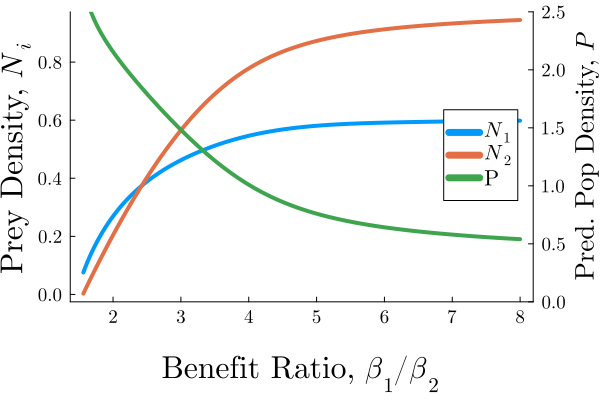

In [18]:
#size_explanatory_plots = (600, 133)
plt_N = plot(
    stable_coexist_t2[:param], 
    stable_coexist_t2[:N1], 
    label = L"N_1",
    linewidth=4
    )
plot!(
    stable_coexist_t2[:param], 
    stable_coexist_t2[:N2], 
    label = L"N_2",
    linewidth=4
    )
plot!([],[],color=3, linewidth=4, label = "P")
plot!(ylab = L"Prey Density, $N_i$",
    xlab = "\n"*param_label_dic[:scale],
    bottommargin = 5mm,
    guidefontsize=20,
    legend = :right
    )#ylab = "Scaled Prey Density\nat Equilibrium"
plot!(
    twinx(), stable_coexist_t2[:param], stable_coexist_t2[:P], 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = L"Pred. Pop Density, $P$",
    color = 3,
    linewidth=4,
    ylims = [0,2.5])
savefig(plt_N, bif_fig_path*"stable_N_t2_scale.pdf")
plt_N


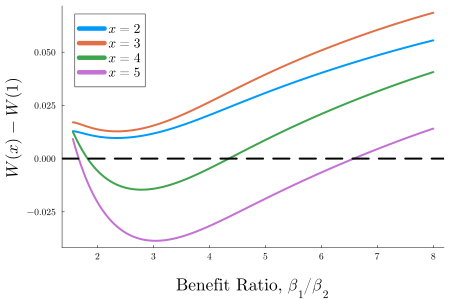

In [19]:
# explanatory figures
# get W mat
num = length(stable_coexist_t2[:N1])
xvec = 1:x_max
Wmat = zeros(num,x_max)
for i in 1:num
    # set up inputs
    N1 = stable_coexist_t2[:N1][i]
    N2 = stable_coexist_t2[:N2][i]
    params_use = deepcopy(params_t2)
    params_use[:scale] = stable_coexist_t2[:param][i]
    params_use = scale_parameters(params_use)
    
    Wmat[i,:] = fun_W(xvec,N1,N2,params_use)
end
# plot heatmap of W
# stable_coexist_t2[:param]: vector for x-axis
# xvec: vector for y-axis (e.g., 1:x_max)
xvec = 1:x_max
plt = plot(
    xlab = "\n"*param_label_dic[:scale],
    ylab = L"W(x) - W(1)",
    bottommargin=5mm)
for x in 2:5 #xvec[2:end]
    plot!(stable_coexist_t2[:param], Wmat[:,x] .- Wmat[:,1], label = L"x=%$x",
    guidefontsize=22, left_margin = 5mm, legendfontsize=18,
    linewidth=4,
    )
end
hline!([0],linestyle=:dash, color = :black, label = nothing,size=(600,400).*1.5)
savefig(plt, bif_fig_path*"W_t2_scale.pdf")
plt
plot!(dpi = 50)



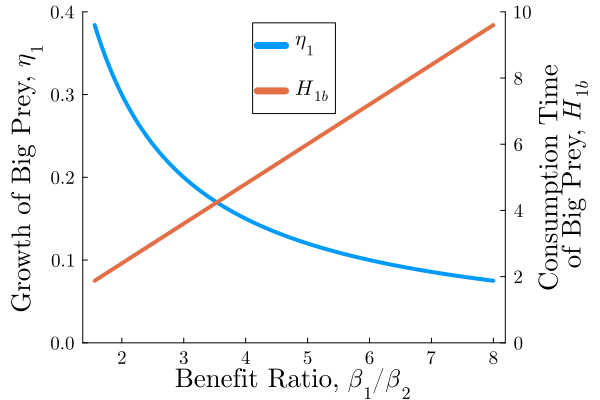

In [20]:
scale = stable_coexist_t2[:param]
@unpack η2, H2b, A1, A2 = params_t2
H1b = scale .* A1 * H2b / A2
η1 = η2 ./ scale

plt = plot(
    scale, η1, label = L"~\eta_1", 
    linewidth=4,
    ylab = L"Growth of Big Prey, $\eta_1$",
    xlab = param_label_dic[:scale],
    left_margin = 5mm,
    legend=:top,
    ylim = (0,0.4),
)
plot!([],[],color=:white, label = " ")
plot!([],[],linewidth=4,color=2,label=L"~H_{1b}")

plot!(twinx(),
    scale, H1b, label = nothing, linewidth=4,color=2,
    ylabel = "Consumption Time\n of Big Prey, "*L"H_{1b}",
    ylim = (0,10),
    right_margin=5mm
    )
savefig(plt, bif_fig_path*"params_t2_scale.pdf")
plt


# Try for other s values???

In [21]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.5,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 10,
    :Tg => .01,
    :d => 100.0,
    :scale => 5.0
)
# type II, vary scale
params_t2 = deepcopy(params_base)
params_t2[:H1a] = params_t2[:H2a] = 0.0
params_t2[:H2b] = 1.0
stable_coexist_t2, gmat_t2 = get_stable_equilibria(params_t2)
∂N2_∂N1_t2, ∂N1_∂N2_t2 = get_apparent_comp_bothways(stable_coexist_t2, gmat_t2, params_t2)

[0.874420969550076, 0.9119326351402006, 0.17646198940289584, 0.01010340837103713, 0.028031051533681437, 0.029430350721828515, 0.0028082386786722384, 3.082746113142515e-5, 1.0060853007364749e-7, 2.2344527254144518e-10, 4.3786366624308836e-13, 7.992598915007829e-16][1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.9999999999964632, 0.0, 1.1468122788740068e-8, -2.583724882988831e-10, 5.200554082800784e-10, -2.6831919605577474e-9, 1.0130055791354805e-8, -2.8201615434992708e-8, 5.853700275669359e-8, -8.845571507299883e-8, 8.769194423590943e-8, -3.745927837618475e-8][0.0, 0.9999999999999467, -5.768839246615161e-9, 2.6085791873048875e-8, -6.989993492205568e-8, 1.229761342444703e-7, -1.4846114329683336e-7, 1.245810935436039e-7, -7.178033370860253e-8, 2.719379649056383e-8, -6.124057074948218e-9, 6.24018294137066e-10][0.9998489945252559, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.0, 0.9995805607141938, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

([-1.8933896720272738, -1.8508176833560686, -1.8196643962341392, -1.796848356177929, -1.7802679200585096, -1.7684397317285399, -1.7602866610343162, -1.7550077087636395, -1.7519951103751816, -1.7507797719836313  …  0.846253480433916, 0.8481245820099571, 0.8500149833179952, 0.8519246739538607, 0.8538536451542422, 0.8558018897696192, 0.8577694022368256, 0.8597561785566702, 0.861762216267249, 0.8621121132592503], [-0.7500986968998733, -0.7638576031206324, -0.7753354331645895, -0.7850217922059527, -0.7932887258843554, -0.8004229316641934, -0.8066479391566473, -0.8121397464511909, -0.8170380717921272, -0.8214545961658265  …  -0.1971336146176814, -0.19789005731946988, -0.1986436339331176, -0.19939428152310926, -0.20014193875350908, -0.20088654586991392, -0.20162804468143236, -0.20236637854359582, -0.2031014923405714, -0.20322866240282544])

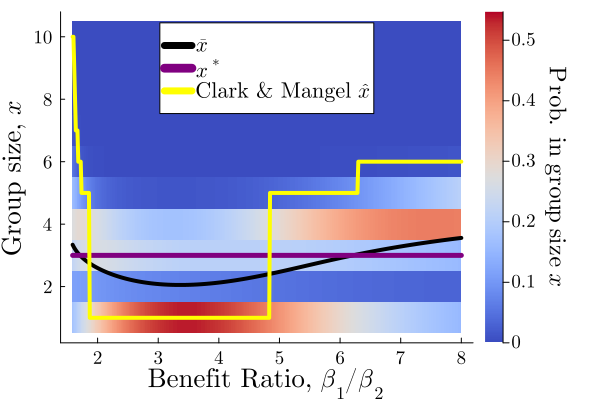

In [22]:
ix_end_below_1 = findfirst( ∂N2_∂N1_t2.> 0)
#ix_end_above = findlast( ∂N2_∂N1_t2.> 0)
plt = plot(
    stable_coexist_t2[:param][1:ix_end_below_1 - 1], # i looked at the values and 207 is about where there's a change
    ∂N2_∂N1_t2[1:ix_end_below_1 - 1], 
    label = L"\partial N_2/\partial N_1", 
    color = 1, 
    ylabel = "Effect of big prey on\n"*"smal prey, "*L"\partial N_2/\partial N_1",
    xlab = "\n"*param_label_dic[:scale],
    ylims = [-50,50]
    )
annotate!((5.5,10,"Facilitatation"))
annotate!((5.5,-10,"Competition"))
plot!(stable_coexist_t2[:param][ix_end_below_1:end], ∂N2_∂N1_t2[ix_end_below_1:end], 
    label = nothing, color = 1)

plot!([], [], color = :white, label = " ")
plot!([],[], color = 2,label = L"\partial N_1/\partial N_2")
plot!(
    twinx(), stable_coexist_t2[:param], ∂N1_∂N2_t2, 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = "Effect of small prey on\n"*L"big prey, $\partial N_1/\partial N_2$",
    color = 2,
    ylims = [-2.5,2.5])
hline!([0], color = :black, linestyle = :dash, linewidth = 2, label = nothing)
plot!(
    legend = :topright,
    rightmargin=4mm,
    leftmargin=4mm,
    bottommargin = 3mm, # prevents xlab from being cutoff
    size=(720,480)
)

#savefig(plt, bif_fig_path*"apparent_comp_t2_scale.pdf")
plt

plt_heat = plot_distribution_heatmap(gmat_t2, stable_coexist_t2, params_t2[:x_max])
plot_opt_line(plt, stable_coexist_t2, params_t2)
plot_mc_line(plt, stable_coexist_t2, params_t2)
plot!(legend=:top)
#savefig(plt_heat, bif_fig_path*"distribution_t2_scale.pdf")
plt_heat



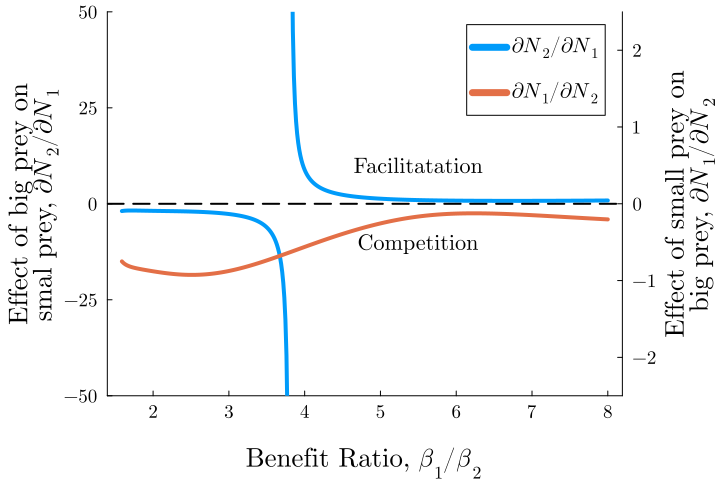

In [23]:
plt

# s = 3


[0.5160113414805136, 0.17307648668348283, 0.9021527194330379, 0.07736818586576776, 0.07170239769287202, 0.1313643891244365, 0.09112577637373924, 0.016308984067996475, 0.000873606178868358, 1.7467189493352224e-5, 1.580394628447542e-7, 7.565910531337158e-10][1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.6594550278492795, 0.0, 0.01729774964045809, 0.0012230869467985167, 0.0035256138063680964, 0.014978491373974785, 0.04834495323101304, 0.08199508732117325, 0.0555745650666386, 0.014775320415013558, 0.0017026799004423296, 9.659061465571597e-5]

┌ Error: Failure to converge with given tolerance = 1.0e-12.
│ Step = 77
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 77.
└ @ BifurcationKit /Users/taliaborofsky/.julia/packages/BifurcationKit/nhoqA/src/continuation/Contbase.jl:67


[0.0, 0.2642843959252067, 1.1576798533132275, 0.004466697797704581, 5.109706032403005e-6, 2.5436681732538846e-7, -3.026683353091379e-7, 2.528985573940073e-7, -1.449444073199522e-7, 5.454696041574495e-8, -1.2176386482481292e-8, 1.2253194533710525e-9][0.9990934107313862, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.0, 0.9995805607141938, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

┌ Error: Failure to converge with given tolerance = 1.0e-12.
│ Step = 98
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 98.
└ @ BifurcationKit /Users/taliaborofsky/.julia/packages/BifurcationKit/nhoqA/src/continuation/Contbase.jl:67


[-1.006090995500336, -0.1868702171870674, -0.2627264555505991, 0.16125510719843114, -0.00025967799523172953, 4.234334063279967e-7, -9.328487084899605e-10, 9.24977430675033e-12, -1.6822100458746849e-12, 2.9085439616930186e-12, -3.282735768364958e-11, 1.3737875610470673][-4.6315620392586935e-10, -0.05911510373384443, 0.3869094728892643, 0.17267638934410623, 0.1680561465920322, 0.1562646057468321, 0.13426448804393865, 0.10578485943953307, 0.07647489723301085, 0.05090450750895207, 0.031334750663495926, 0.01791711305508054][0.16567890291105322, -5.721927116150197e-9, 0.5478352635375466, 0.14444780090415493, 0.14812959280366805, 0.19126750274352788, 0.16406136336717944, 0.08196810344089243, 0.025513449107576264, 0.005384278483017832, 0.0008244911075932785, 9.642574440618032e-5]

┌ Warning: continue_sp failed for coexist specialpoint 4: ErrorException("Newton failed to converge. Required for the computation of the initial tangent.")
└ @ CooperativeHuntingPkg.MyBifTools /Users/taliaborofsky/Documents/Postdoc/Collaborations/CH_GroupFormation/CH_code/Julia_version/CooperativeHuntingPkg/src/MyBifTools.jl:769
┌ Error: Failure to converge with given tolerance = 1.0e-12.
│ Step = 45
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 45.
└ @ BifurcationKit /Users/taliaborofsky/.julia/packages/BifurcationKit/nhoqA/src/continuation/Contbase.jl:67
┌ Error: Failure to converge with given tolerance = 1.0e-12.
│ Step = 110
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 110.
└ @ 

[1.0000000011050172, 1.0000000035710397, -1.0099103864728211e-8, -1.5157180468492532e-11, -6.630162404146209e-14, -8.90044995422232e-16, -5.767466763582071e-18, -1.7360223435340602e-20, -4.100763388167661e-23, -8.88412083678137e-26, -1.812698880777085e-28, -3.5034330170713437e-31][1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][-1.9093513039299566e-6, 2.5204080323470012e-26, 1.719514058508799, 0.7391766504756818, 0.4236663870425755, 0.182120276837171, 0.06263016774324948, 0.01794855501202647, 0.004408900259476353, 0.0009476335319221057, 0.00018105022748541542, 3.113157318139068e-5]

┌ Error: Failure to converge with given tolerance = 1.0e-12.
│ Step = 140
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 140.
└ @ BifurcationKit /Users/taliaborofsky/.julia/packages/BifurcationKit/nhoqA/src/continuation/Contbase.jl:67


[0.16567890449773545, -6.851156610649369e-30, 0.5478353326687727, 0.144447818925303, 0.1481296059196372, 0.19126750964097702, 0.16406135842892228, 0.08196809462140371, 0.02551344415968241, 0.0053842769368557695, 0.0008244907894456233, 9.642569725114382e-5][0.9804646847202073, 1.3299715223955944e-135, 0.0047815972989045654, 0.00039909835588520457, 0.0006244619407210105, 0.0010642331112559447, 0.0018128320337482198, 0.00274708733829072, 0.003160364103051774, 0.002139306574509879, 0.0006837279239264989, 9.671862180741105e-5][1.0000000001534353, 0.0, -1.0353245859574148e-9, -8.602172739348534e-12, -5.311459635258696e-12, -7.461332363324309e-12, -1.2343468001827618e-11, -1.6028868623108016e-11, -1.0771125931372016e-11, -2.9210312460171545e-12, -3.1691688925390007e-13, -1.5073528525877542e-14]

┌ Error: Failure to converge with given tolerance = 1.0e-12.
│ Step = 111
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 111.
└ @ BifurcationKit /Users/taliaborofsky/.julia/packages/BifurcationKit/nhoqA/src/continuation/Contbase.jl:67
┌ Warning: continue_sp failed for N2_extinct specialpoint 4: ErrorException("Newton failed to converge. Required for the computation of the initial tangent.")
└ @ CooperativeHuntingPkg.MyBifTools /Users/taliaborofsky/Documents/Postdoc/Collaborations/CH_GroupFormation/CH_code/Julia_version/CooperativeHuntingPkg/src/MyBifTools.jl:769


[8.889817189612216e-29, -0.17855575765860998, 0.002072935463531447, 3.155469474940144e-6, 1.8616999961444855e-6, 2.193077416116308e-6, 4.141889377203167e-6, 1.169350935039495e-5, 4.958841082518396e-5, 0.0003419188587069611, 0.004916019984943721, 1.4556529655495691][2.8802936200708994e-27, -0.10083988136412762, 0.09460427602308209, 0.035748211462026544, 0.043169282062326196, 0.05974211688069545, 0.08504417468741833, 0.11914854331434559, 0.1610488335761251, 0.20808161864856567, 0.25594615339277665, 0.2992904540700504]

┌ Warning: continue_sp failed for N1_extinct specialpoint 2: ArgumentError("matrix contains Infs or NaNs")
└ @ CooperativeHuntingPkg.MyBifTools /Users/taliaborofsky/Documents/Postdoc/Collaborations/CH_GroupFormation/CH_code/Julia_version/CooperativeHuntingPkg/src/MyBifTools.jl:769


[1.0683979155280486e-27, -0.05911518575318299, 0.38690862191329034, 0.17267602821056327, 0.16805593439790464, 0.15626459248134944, 0.1342646622858295, 0.10578515723274447, 0.07647523585357233, 0.0509048186313326, 0.03133499667615332, 0.017917285675639816][5.528176963771809e-28, -0.045476172631725445, 0.5354135601251363, 0.22701828942107657, 0.18656523370167807, 0.13832183898853406, 0.0916011653505654, 0.054390417714721404, 0.02916420519688905, 0.014228052827965854, 0.0063600581283222695, 0.0026214778808742946][-5.002398096118379e-28, -9.508876778262513e-10, 0.9473777134301693, 0.22438113804060464, 0.07085789863135561, 0.016782299064418704, 0.0031798353376401365, 0.0005020842074396128, 6.795191525818344e-5, 8.047016580566055e-6, 8.470627193425576e-7, 8.024883748016692e-8]

┌ Error: Failure to converge with given tolerance = 1.0e-12.
│ Step = 45
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 45.
└ @ BifurcationKit /Users/taliaborofsky/.julia/packages/BifurcationKit/nhoqA/src/continuation/Contbase.jl:67
┌ Warning: continue_sp failed for N1_extinct specialpoint 5: ErrorException("Newton failed to converge. Required for the computation of the initial tangent.")
└ @ CooperativeHuntingPkg.MyBifTools /Users/taliaborofsky/Documents/Postdoc/Collaborations/CH_GroupFormation/CH_code/Julia_version/CooperativeHuntingPkg/src/MyBifTools.jl:769
┌ Error: Failure to converge with given tolerance = 1.0e-12.
│ Step = 60
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 60.
└ @

[-5.0e-324, 1.0000007808787663, -1.920339360998496e-6, -2.333800488556957e-9, -2.499139248907568e-12, -2.2485001279445907e-15, -1.7219315381082607e-18, -1.1427621106812967e-21, -6.67824586362165e-25, -3.482903946139047e-28, -1.6390949305655518e-31, -7.02504442919662e-35][1.000000000000678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.0, 1.000000000000031, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]hi

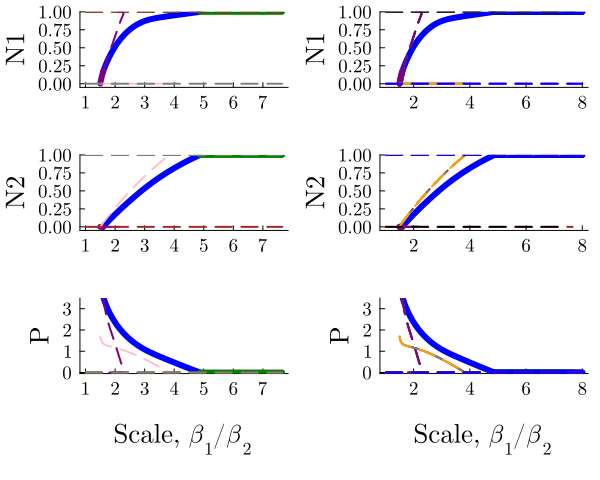

In [24]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 3.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 10,
    :Tg => .01,
    :d => 100.0,
    :scale => 2.0
)
# type II, vary scale
params_t2 = deepcopy(params_base)
params_t2[:H1a] = params_t2[:H2a] = 0.0
params_t2[:H2b] = 1.0
p_nt = NamedTuple(scale_parameters(params_t2))


br_list, extra_branches = diagram_2_recursion(
    p_nt, paramkey = :scale; p_min = 1.01, p_max = 8.0, 
    lens = (@optic _.scale), systemfunction = fullsystem_scaled);
#plot_comparison_branches(br_list, extra_branches; ymax = 3.5)
plot_comparison_branches_filtered(br_list, [br_list...,extra_branches...], :scale; ymax = 3.5)

[0.5160113414805136, 0.17307648668348283, 0.9021527194330379, 0.07736818586576776, 0.07170239769287202, 0.1313643891244365, 0.09112577637373924, 0.016308984067996475, 0.000873606178868358, 1.7467189493352224e-5, 1.580394628447542e-7, 7.565910531337158e-10][1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.6594550278492795, 0.0, 0.01729774964045809, 0.0012230869467985167, 0.0035256138063680964, 0.014978491373974785, 0.04834495323101304, 0.08199508732117325, 0.0555745650666386, 0.014775320415013558, 0.0017026799004423296, 9.659061465571597e-5]

┌ Error: Failure to converge with given tolerance = 1.0e-12.
│ Step = 77
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 77.
└ @ BifurcationKit /Users/taliaborofsky/.julia/packages/BifurcationKit/nhoqA/src/continuation/Contbase.jl:67


[0.0, 0.2642843959252067, 1.1576798533132275, 0.004466697797704581, 5.109706032403005e-6, 2.5436681732538846e-7, -3.026683353091379e-7, 2.528985573940073e-7, -1.449444073199522e-7, 5.454696041574495e-8, -1.2176386482481292e-8, 1.2253194533710525e-9][0.9990934107313862, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.0, 0.9995805607141938, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

┌ Error: Failure to converge with given tolerance = 1.0e-12.
│ Step = 98
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 98.
└ @ BifurcationKit /Users/taliaborofsky/.julia/packages/BifurcationKit/nhoqA/src/continuation/Contbase.jl:67


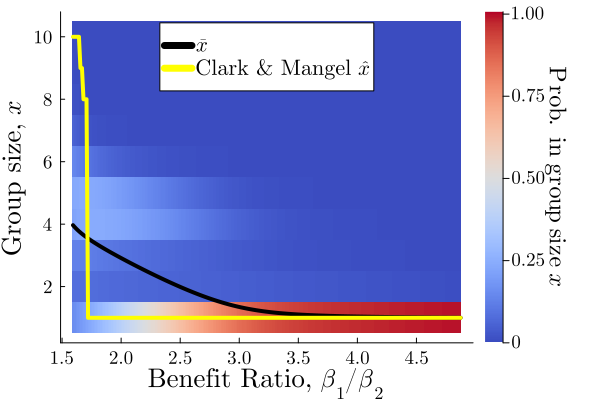

In [25]:

stable_coexist_t2, gmat_t2 = get_stable_equilibria(params_t2)
∂N2_∂N1_t2, ∂N1_∂N2_t2 = get_apparent_comp_bothways(stable_coexist_t2, gmat_t2, params_t2)




plt = plot(
    stable_coexist_t2[:param], 
    ∂N2_∂N1_t2, 
    label = L"\partial N_2/\partial N_1", 
    color = 1, 
    ylabel = "Effect of big prey on\n"*"smal prey, "*L"\partial N_2/\partial N_1",
    xlab = "\n"*param_label_dic[:scale],
    ylims = [-50,50]
    )
annotate!((5.5,10,"Facilitatation"))
annotate!((5.5,-10,"Competition"))

plot!([], [], color = :white, label = " ")
plot!([],[], color = 2,label = L"\partial N_1/\partial N_2")
plot!(
    twinx(), stable_coexist_t2[:param], ∂N1_∂N2_t2, 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = "Effect of small prey on\n"*L"big prey, $\partial N_1/\partial N_2$",
    color = 2,
    ylims = [-2.5,2.5])
hline!([0], color = :black, linestyle = :dash, linewidth = 2, label = nothing)
plot!(
    legend = :topright,
    rightmargin=4mm,
    leftmargin=4mm,
    bottommargin = 3mm, # prevents xlab from being cutoff
    size=(720,480)
)

#savefig(plt, bif_fig_path*"apparent_comp_t2_scale.pdf")
plt

plt_heat = plot_distribution_heatmap(gmat_t2, stable_coexist_t2, params_t2[:x_max])
plot_mc_line(plt, stable_coexist_t2, params_t2)
plot!(legend=:top)
#savefig(plt_heat, bif_fig_path*"distribution_t2_scale.pdf")
plt_heat




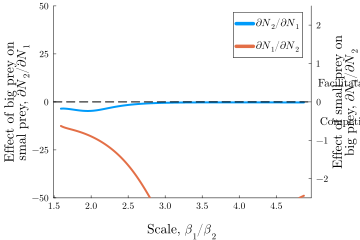

In [149]:
plot!(plt, dpi = 50)

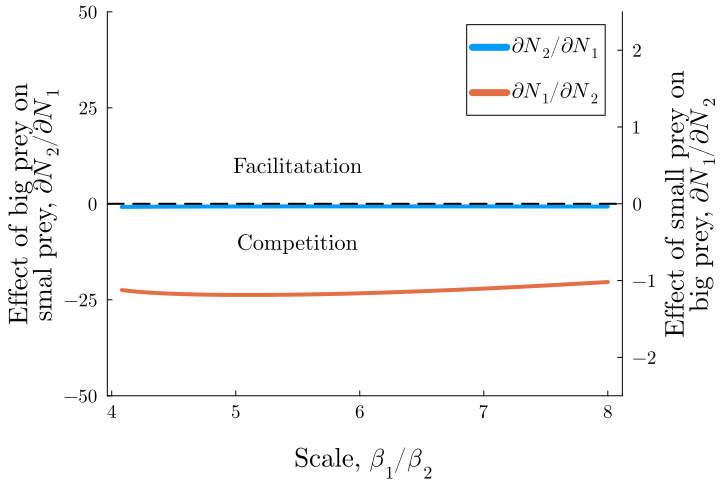

In [156]:
plt